In [1]:
!pip install pytorch-tdnn

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-tdnn: filename=pytorch_tdnn-1.1.0-py3-none-any.whl size=6308 sha256=80422f34af3a3b8c0e7c8a54a04537f44c1cb68a2d7abf121ceb250064777b63
  Stored in directory: /root/.cache/pip/wheels/63/ba/85/d188dabea623d7ab3a856f38ce111ded35781455929e7fdd0e
Successfully built pytorch-tdnn


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

import librosa 
import librosa.display
import IPython.display as ipd
from tqdm.notebook import tqdm
import pickle

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch import nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
import glob
import random

from sklearn.metrics import accuracy_score
from pytorch_tdnn.tdnn import TDNN as TDNNLayer

Инициализация класса извлечения y-векторов

In [3]:
# tf-SE Downsampling Block
class tfSE(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        # frequence re-calibration - частотное преобразование
        self.freq_recal = nn.Sequential(nn.Linear(channels, channels), nn.Sigmoid())
        
        # time re-calibration - временное преобразование
        self.time_recal = nn.Sequential(nn.Linear(channels, 1), nn.Sigmoid())

    def forward(self, x):
        
        # формула 2
        avgpool = nn.AvgPool1d(x.shape[-1], stride=1)
        freq_recal = self.freq_recal(avgpool(x).squeeze(-1))
        x = x * freq_recal.unsqueeze(-1)
        
        # формула 3
        xt = self.time_recal(x.permute(0, 2, 1)).T.permute(2, 0, 1)
        out = xt * x

        return out

class WaveformEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        def baselayer(n_in, n_out, k, stride, padding=0):
            return nn.Sequential(
                nn.Conv1d(n_in, n_out, k, stride=stride, bias=False, padding=padding),
                nn.Dropout(p=0.0),
                nn.InstanceNorm1d(n_out, affine=False),
                nn.ReLU()
            )
        
        # 3 параллельных канала фильтров
        self.wavefilter = nn.ModuleList().extend([
                nn.Sequential(
                    baselayer(1, 90, 36, 18, 0), 
                    baselayer(90, 192, 5, 1, 2)
                ),
                nn.Sequential(
                    baselayer(1, 90, 18, 9, 0), 
                    baselayer(90, 160, 5, 2, 0)
                ),
                nn.Sequential(
                    baselayer(1, 90, 12, 6, 0),
                    baselayer(90, 160, 5, 3, 0)
                )
        ])
              
        self.skip1 = nn.MaxPool1d(kernel_size=5, stride=8)
        self.skip2 = nn.MaxPool1d(kernel_size=3, stride=4, padding=1)
        self.skip3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.conv1 = baselayer(512, 512, 5, 2)
        self.conv2 = baselayer(512, 512, 3, 2)
        self.conv3 = baselayer(512, 512, 3, 2, padding=2)
        
        self.am1 = tfSE(512)
        self.am2 = tfSE(512)
        self.am3 = tfSE(512)
        self.am4 = tfSE(512*4)

    def forward(self, x):
        enc = []
        ft_shape = []
        
        # Multiscale filtering layer
        for conv in self.wavefilter:
            enc.append(conv(x))
            ft_shape.append(conv(x).shape[-1])
            
        #Выбираем наименьшую длину и конкатенируем по ней
        ft_max = np.min(np.array(ft_shape))
        enc = torch.cat((enc[0][:, :, :ft_max], enc[1][:, :, :ft_max], enc[2][:, :, :ft_max]), dim=1)
        
        #  Multi-level Feature Map Aggregation
        skip1_out = self.skip1(enc)
        out = self.conv1(enc)
        out = self.am1(out)
        skip2_out = self.skip2(out)
        out = self.conv2(out)
        out = self.am2(out)
        skip3_out = self.skip3(out)
        out = self.conv3(out)
        out = self.am3(out)
        
        t_max = np.min(np.array([skip1_out.shape[-1], skip2_out.shape[-1], skip3_out.shape[-1], out.shape[-1]]))
        out = torch.cat((skip1_out[:, :, :t_max], skip2_out[:, :, :t_max], skip3_out[:, :, :t_max], out[:, :, :t_max]), dim=1)
        out = self.am4(out)
        
        return out

Инициализация класса агрегатора

In [4]:
# Frame aggregator
class Aggregator(nn.Module):
    def __init__(self, feature_dim=2048, wavlength=535, num_classes=109, embed_dim=128, p_dropout=0.0):
        super(Aggregator, self).__init__()
        
        self.tdnn5 = TDNNLayer(feature_dim, 512, [-2,-1,0,1,2])
        self.tdnn3 = TDNNLayer(512, 512, [-2,0,2])
        self.tdnn1 = TDNNLayer(512, 512, [0])
        self.tdnn_out = TDNNLayer(512, 1500, [0])
        
        self.layer_norm = nn.LayerNorm(wavlength)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(3000, 512)
        self.bn = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(p=p_dropout)
        self.lrelu = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(512, embed_dim)
        self.fc3 = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):

        x = self.tdnn5(x)
        x = self.layer_norm(x)
        x = self.relu(x)
        
        x = self.tdnn3(x)
        x = self.layer_norm(x)
        x = self.relu(x)
        
        x = self.tdnn3(x)
        x = self.layer_norm(x)
        x = self.relu(x)
        
        x = self.tdnn1(x)
        x = self.layer_norm(x)
        x = self.relu(x)
        
        x = self.tdnn_out(x)
        x = self.layer_norm(x)
        x = self.relu(x)
               
        stats = torch.cat((x.mean(dim=2), x.std(dim=2)), dim=1)
               
        x = self.fc1(stats)
               
        x = self.bn(x)
        x = self.lrelu(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.dropout_fc1(x)
        x = self.fc3(x)
        
        return x

Объединение частей модели

In [5]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        
        self.waveenc = WaveformEncoder()
        self.agg = Aggregator()
        
    def forward(self, x, labels=None):
        
        x = self.waveenc(x)
        x = self.agg(x)
        
        return x

Инициализация дататсета для обучения. Если длина вавки меньше 3.5 сек, она дублируется сама собой, и берутся последние 3.5 сек. Если длина больше 3.5 сек, берутся последние 3.5 сек

In [6]:
class CustomDataset(Dataset):
    def __init__(self, path_wav, y, time_lenght=3.5):
        super(CustomDataset).__init__()
        self.y = y
        self.path_wav = path_wav
        self.time_lenght = time_lenght
        
    def __len__(self):
        return len(self.path_wav)

    def __getitem__(self, idx):
        y_idx = self.y[idx]
        wav, sr = librosa.load(self.path_wav[idx])
        random_segment = self.get_random_lenght_segment(wav, sr)
        return torch.Tensor(random_segment), torch.tensor(y_idx, dtype=torch.long), self.path_wav[idx]
        
    def get_random_lenght_segment(self, wav, sr):
        segment_length = int(self.time_lenght * sr)
        while len(wav) < segment_length:
            wav = np.hstack((wav, wav))
        return wav[-segment_length:]

Загрузим корпус VCTK

In [7]:
path = '/kaggle/input/english-multispeaker-corpus-for-voice-cloning/VCTK-Corpus/VCTK-Corpus/wav48'
filepath = glob.glob(path + "/**/*")
filepath.remove('/kaggle/input/english-multispeaker-corpus-for-voice-cloning/VCTK-Corpus/VCTK-Corpus/wav48/p376/p376_295.raw')
label = [x[-12:-8] for x in tqdm(filepath)]

  0%|          | 0/44242 [00:00<?, ?it/s]

In [8]:
y = LabelEncoder().fit_transform(label)

Разделим данные на обучение и валидации в пропорции 80/20

In [9]:
X_train, X_val, y_train, y_val = train_test_split(filepath, y, shuffle=True, test_size=0.2, random_state=42)

In [10]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

batch_size = 64
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size,
                              drop_last=True
                              )
val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size,
                           drop_last=True)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [12]:
model.load_state_dict(torch.load('../input/model-3ep/model_3ep.pkl'))

<All keys matched successfully>

Функция для визуализации кривых обучения

In [13]:
def learning_curves(train, val, txt='loss'):
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(train)+1), train, label='train {}'.format(txt))
    plt.plot(range(1, len(val)+1), val, label='validation {}'.format(txt))
    plt.title('Training history', fontsize=14)
    plt.ylabel('{}'.format(txt), fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid()
    plt.show()

Функция обучения

In [15]:
def train(train_dataloader, val_dataloader, model, optimizer, loss_fn, epoch):
    losses_train = []
    losses_val = []
    accuracy_train = []
    accuracy_val = []
    EER_train = []
    EER_val = []
    for i in range(epoch):
        loss_train = []
        acc_train = []
        eer_train = []
        eer_val = []
        loss_val = []
        acc_val = []
        m = nn.Softmax(dim=1)
        model.train()
        for d in tqdm(train_dataloader):
            optimizer.zero_grad()
            X = d[0].float().unsqueeze(1).to(device)
            y = d[1].to(device)
            predict = model(X)
            logits = m(predict).detach().cpu().numpy().argmax(axis=-1).flatten().tolist()
            loss = loss_fn(predict, y)
            loss_train.append(loss.item())
            acc_train.append(accuracy_score(logits, y.cpu().numpy()))
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            model.eval()
            with torch.no_grad():
                optimizer.zero_grad()
                for d_v in tqdm(val_dataloader):
                    X_val = d_v[0].unsqueeze(1).float().to(device)
                    y_val = d_v[1].to(device)
                    predict_val = model(X_val)
                    loss_v = loss_fn(predict_val, y_val)
                    logits_val = m(predict_val).detach().cpu().numpy().argmax(axis=-1).flatten().tolist()
                    loss_val.append(loss_v.item())
                    acc_val.append(accuracy_score(logits_val, y_val.cpu().numpy()))

            print('')
            print('---Train---')
            print('Epoch: {}, Accuracy: {}, Loss: {}'.format(i, np.mean(acc_train), np.mean(loss_train)))
            print('---Validation---')
            print('Epoch: {}, Accuracy: {}, Loss: {}'.format(i, np.mean(acc_val), np.mean(loss_val)))
            print('')
            torch.save(model.state_dict(), f"model_4ep.pkl")
        losses_train.append(np.mean(loss_train))
        losses_val.append(np.mean(loss_val))
        accuracy_train.append(np.mean(acc_train))
        accuracy_val.append(np.mean(acc_val))
    return {'losses_train': losses_train,
           'losses_val': losses_val,
           'accuracy_train': accuracy_train,
           'accuracy_val': accuracy_val
            }

In [16]:
epoch = 1
dct_history = train(train_dataloader, val_dataloader, model, optimizer, criterion, epoch)

  0%|          | 0/553 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]


---Train---
Epoch: 0, Accuracy: 0.9895739150090416, Loss: 0.06574627048559958
---Validation---
Epoch: 0, Accuracy: 0.9228940217391305, Loss: 0.27430600726949994



Обучение осуществлялось в несколько этапов, чтобы воспроизвести кривые обучения были сохранены словари с данными о функции потерь и точности по эпохам.

In [18]:
with open('dct_history_4epoch.pkl', 'wb') as f:
    pickle.dump(dct_history, f)

In [52]:
with open('../input/dct-history/dct_history_2epoch.pkl', "rb") as f:
    dct_history1  = pickle.load(f)
with open('../input/dct-history/dct_history_3epoch.pkl', "rb") as f:
    dct_history2  = pickle.load(f)

In [53]:
import copy
def mergeDict(dict1, dict2):
    dct_e = copy.deepcopy(dict1)
    for k, v in dict2.items():
        dct_e[k].extend(v)
    return dct_e

In [55]:
dct_12 = mergeDict(dct_history1, dct_history2)
dct_all = mergeDict(dct_12, dct_history)

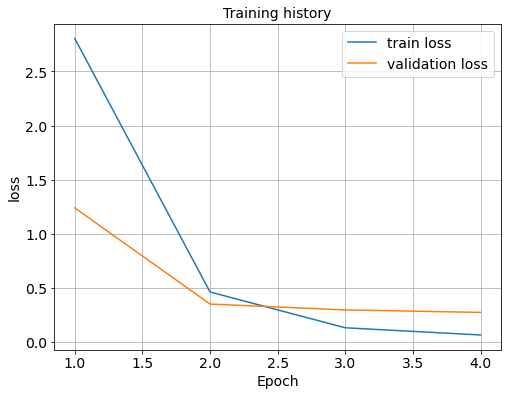

In [56]:
learning_curves(dct_all['losses_train'], dct_all['losses_val'], txt='loss')

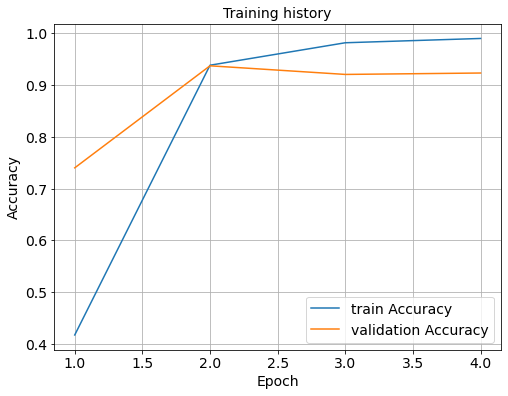

In [57]:
learning_curves(dct_all['accuracy_train'], dct_all['accuracy_val'], txt='Accuracy')

Функция оценки точности обученной модели

In [59]:
def predict(test_dataloader, model, criterion):
    loss_test = []
    y_test = []
    y_predict = []
    acc_test = []
    m = nn.Softmax(dim=1)
    model.eval()
    with torch.no_grad():
        optimizer.zero_grad()
        for d_t in tqdm(test_dataloader):
            X_t = d_t[0].unsqueeze(1).float().to(device)
            y_t = d_t[1].to(device)
            predict_t = model(X_t)
            loss_t = criterion(predict_t, y_t)
            logits_t = m(predict_t).detach().cpu().numpy().argmax(axis=-1).flatten().tolist()
            loss_test.append(loss_t.item())
            acc_test.append(accuracy_score(logits_t, y_t.cpu().numpy()))
            y_test.extend(y_t.cpu().numpy())
            y_predict.extend(logits_t)
    print('---testing---')
    print('Accuracy: {}, Loss: {}'.format(np.mean(acc_test), np.mean(loss_test)))
    return y_test, y_predict

По повторному прогону на валидационных данных для построения confusion_matrix достаточно сложно осуществлять какой-то детальный анализ. Тем не менее, это позволяет визуализировать точность работы модели (основные предсказания (корректные) на диагонали).

In [60]:
y_test, y_predict = predict(val_dataloader, model, criterion)

  0%|          | 0/138 [00:00<?, ?it/s]

---testing---
Accuracy: 0.9228940217391305, Loss: 0.27430600726949994


In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_predict))

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def show_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize=(50,40))
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":18})
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment', fontsize=18)
    plt.xlabel('Predicted sentiment', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

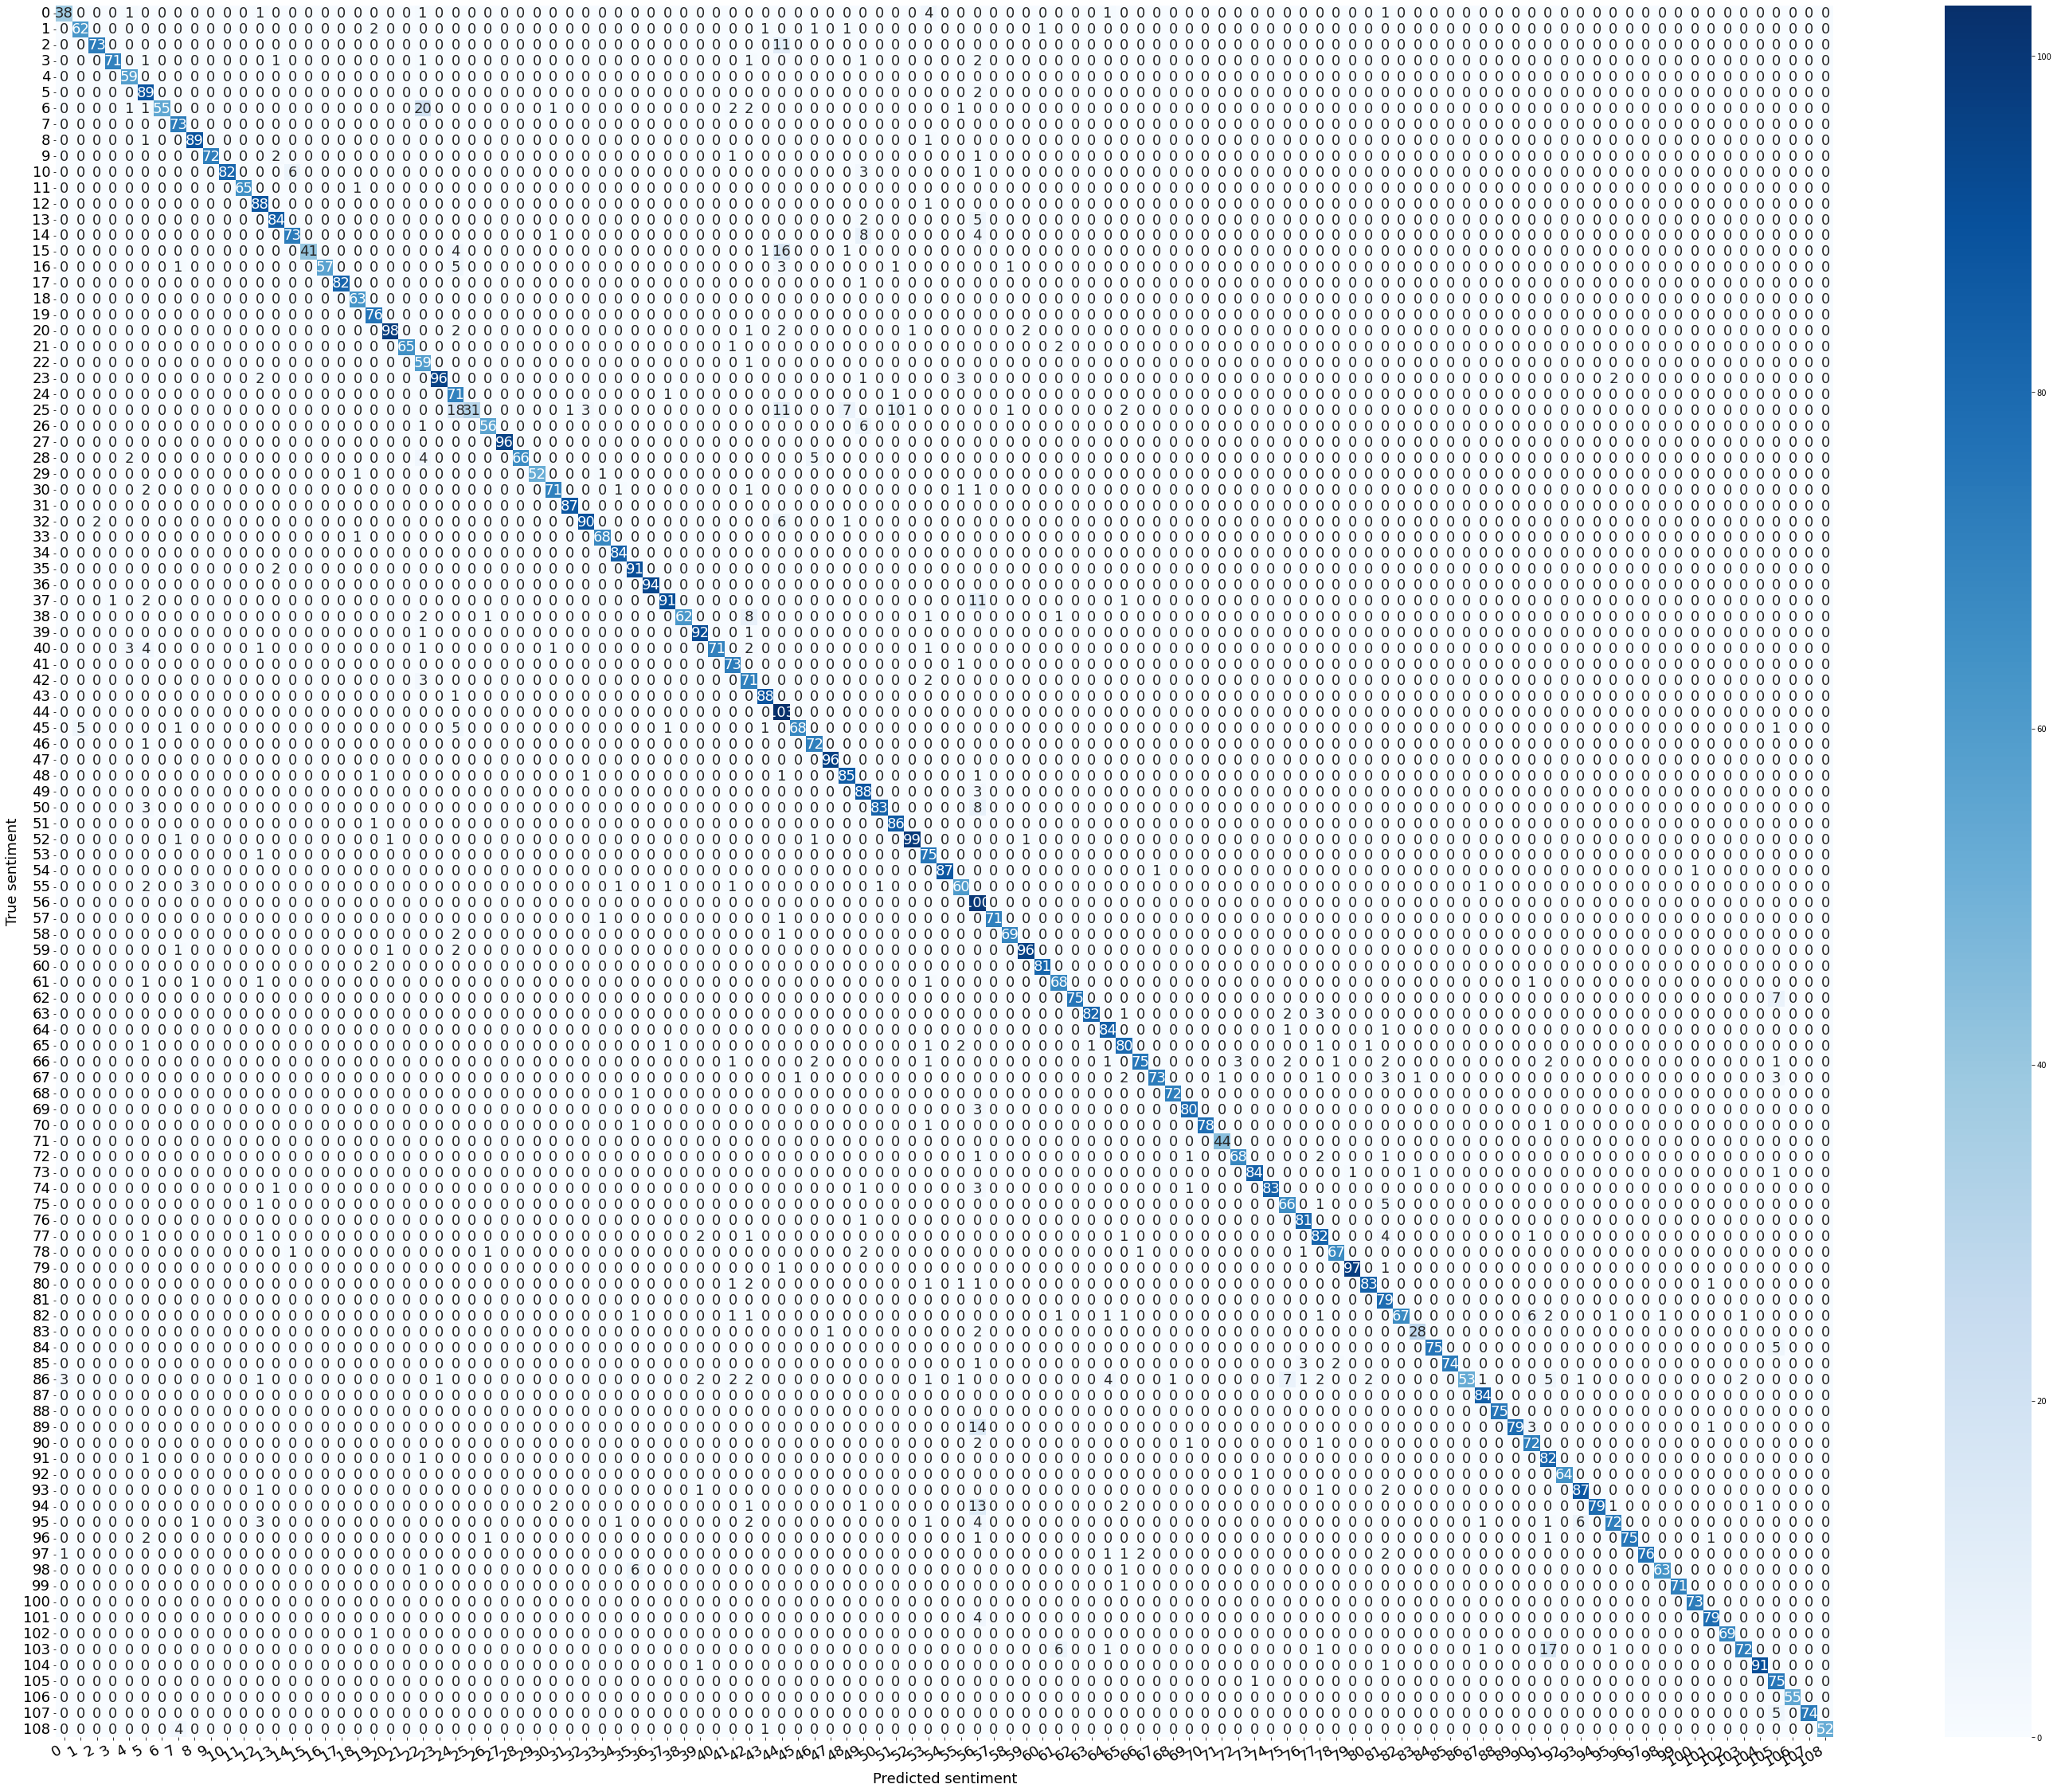

In [63]:
show_confusion_matrix(y_test, y_predict)